**Load in packages & dataset**

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

In [2]:
df = pd.read_csv('yelp_labelled.txt', names=['review', 'sentiment'], sep='\t')

In [3]:
df.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


**Preprocess text data by removing punctuations**

In [4]:
import string

In [5]:
table = str.maketrans('', '', string.punctuation)

In [6]:
processed = [a.translate(table) for a in df['review']]

In [7]:
df2 = pd.concat([df, pd.Series(processed, name='review_processed')],axis=1)

In [8]:
df2 = df2.drop('review',axis=1)

In [9]:
df2.head()

,sentiment,review_processed
0,1,Wow Loved this place
1,0,Crust is not good
2,0,Not tasty and the texture was just nasty
3,1,Stopped by during the late May bank holiday of...
4,1,The selection on the menu was great and so wer...


In [10]:
y = df2['sentiment'].values

In [11]:
X = df2['review_processed'].values

In [12]:
X[1]

'Crust is not good'

**Split into training/testing set**

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Tokenize and pad vectorized text data**

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
max_words = 2000
max_len = 100

In [17]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [18]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

**Simple dense network with embedding layer**

In [20]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=max_len))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 8)            80000     
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 801       
Total params: 80,801
Trainable params: 80,801
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 0s 6ms/step - loss: 0.6944 - accuracy: 0.5172 - val_loss: 0.6953 - val_accuracy: 0.4625
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6889 - accuracy: 0.5266 - val_loss: 0.6941 - val_accuracy: 0.4625
Epoch 3/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6840 - accuracy: 0.5969 - val_loss: 0.6939 - val_accuracy: 0.4625
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6776 - accuracy: 0.5703 - val_loss: 0.6906 - val_accuracy: 0.5688
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6693 - accuracy: 0.7937 - val_loss: 0.6913 - val_accuracy: 0.4750
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6598 - accuracy: 0.7734 - val_loss: 0.6879 - val_accuracy: 0.5500
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6478 - accuracy: 0.8859 - val_loss: 0.6854 - val_accuracy: 0.6062
Epoch 8/10
20/20 [==

In [24]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [25]:
def plot_measures(hist):
    
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    plt.clf()
    
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    plt.clf()
    

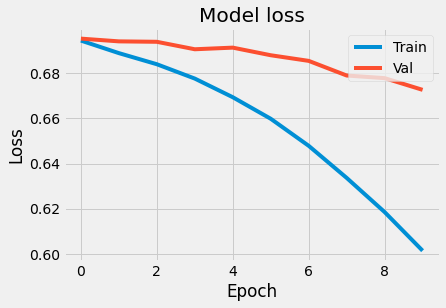

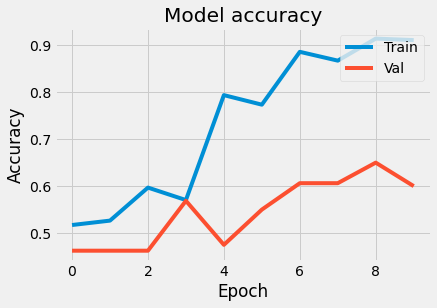

<Figure size 432x288 with 0 Axes>

In [26]:
plot_measures(hist=hist)

**Pre-computed embedding layer using GloVe**

In [27]:
import os
import numpy as np

In [28]:
gdir = '/Users/brianjmpark/Desktop/workspace/nlp/glove.6B/'

In [29]:
embeddings_index = {}

In [30]:
file = open(os.path.join(gdir, 'glove.6B.100d.txt'))

In [31]:
for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
file.close()

In [32]:
embedding_dim = 100
word_index = tokenizer.word_index

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [56]:
model = Sequential()
embedding_layer = Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          200000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 520,065
Trainable params: 320,065
Non-trainable params: 200,000
_________________________________________________________________


In [58]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 0s 6ms/step - loss: 0.6563 - accuracy: 0.6078 - val_loss: 0.6847 - val_accuracy: 0.6250
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4790 - accuracy: 0.8000 - val_loss: 0.6637 - val_accuracy: 0.6313
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4154 - accuracy: 0.8141 - val_loss: 0.6253 - val_accuracy: 0.6313
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.9094 - val_loss: 0.6644 - val_accuracy: 0.6313
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 0.2624 - accuracy: 0.9109 - val_loss: 0.6326 - val_accuracy: 0.6562
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.2039 - accuracy: 0.9391 - val_loss: 0.6725 - val_accuracy: 0.6812
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9641 - val_loss: 0.7787 - val_accuracy: 0.6500
Epoch 8/10
20/20 [==

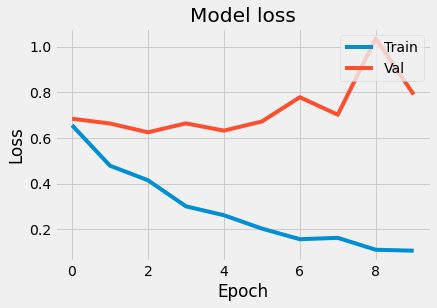

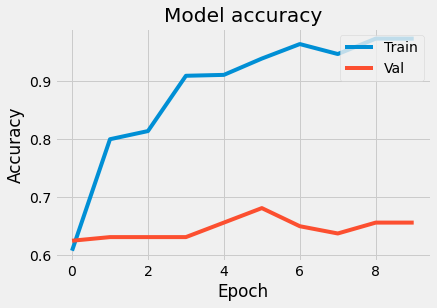

<Figure size 432x288 with 0 Axes>

In [60]:
plot_measures(hist=hist)

**Recurrent network implementation with bidirectional LSTM**

In [68]:
from tensorflow.keras.layers import LSTM, Bidirectional

In [72]:
model = Sequential()
embedding_layer = Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

In [73]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 284,609
Trainable params: 84,609
Non-trainable params: 200,000
_________________________________________________________________


In [74]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [77]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
20/20 [==============================] - 0s 24ms/step - loss: 0.3338 - accuracy: 0.8609 - val_loss: 0.5439 - val_accuracy: 0.7625
Epoch 2/20
20/20 [==============================] - 0s 23ms/step - loss: 0.3249 - accuracy: 0.8656 - val_loss: 0.5478 - val_accuracy: 0.7812
Epoch 3/20
20/20 [==============================] - 1s 27ms/step - loss: 0.2903 - accuracy: 0.8875 - val_loss: 0.5153 - val_accuracy: 0.7437
Epoch 4/20
20/20 [==============================] - 1s 27ms/step - loss: 0.2954 - accuracy: 0.8828 - val_loss: 0.5320 - val_accuracy: 0.7375
Epoch 5/20
20/20 [==============================] - 0s 23ms/step - loss: 0.2722 - accuracy: 0.8844 - val_loss: 0.5302 - val_accuracy: 0.7250
Epoch 6/20
20/20 [==============================] - 0s 23ms/step - loss: 0.2499 - accuracy: 0.9031 - val_loss: 0.5610 - val_accuracy: 0.7688
Epoch 7/20
20/20 [==============================] - 0s 24ms/step - loss: 0.2154 - accuracy: 0.9203 - val_loss: 0.5617 - val_accuracy: 0.7437
Epoch 8/20
20

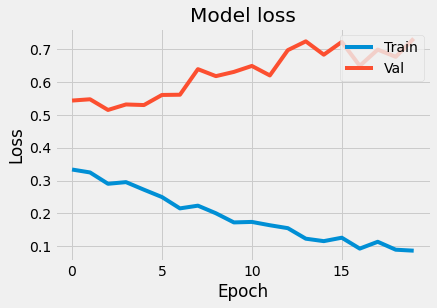

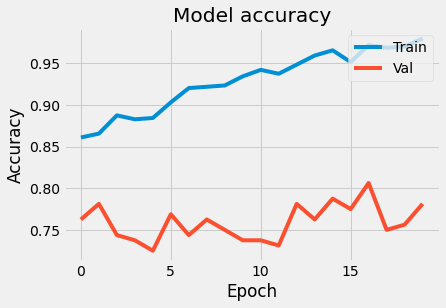

<Figure size 432x288 with 0 Axes>

In [78]:
plot_measures(hist=hist)

**Adjust hyperparameters and add dropout to above model**

In [84]:
from tensorflow.keras.optimizers import RMSprop

In [79]:
model = Sequential()
embedding_layer = Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

In [85]:
model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
10/10 [==============================] - 1s 108ms/step - loss: 0.1405 - accuracy: 0.9531 - val_loss: 0.6376 - val_accuracy: 0.7625
Epoch 2/20
10/10 [==============================] - 1s 76ms/step - loss: 0.1345 - accuracy: 0.9516 - val_loss: 0.6500 - val_accuracy: 0.7688
Epoch 3/20
10/10 [==============================] - 1s 100ms/step - loss: 0.1524 - accuracy: 0.9500 - val_loss: 0.6178 - val_accuracy: 0.7937
Epoch 4/20
10/10 [==============================] - 1s 88ms/step - loss: 0.1381 - accuracy: 0.9484 - val_loss: 0.6258 - val_accuracy: 0.7875
Epoch 5/20
10/10 [==============================] - 1s 87ms/step - loss: 0.1209 - accuracy: 0.9531 - val_loss: 0.6518 - val_accuracy: 0.7750
Epoch 6/20
10/10 [==============================] - 1s 83ms/step - loss: 0.1714 - accuracy: 0.9406 - val_loss: 0.6008 - val_accuracy: 0.7812
Epoch 7/20
10/10 [==============================] - 1s 83ms/step - loss: 0.1266 - accuracy: 0.9578 - val_loss: 0.6234 - val_accuracy: 0.7937
Epoch 8/20


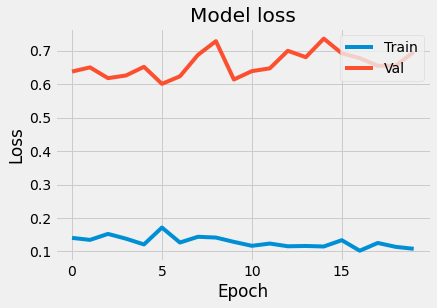

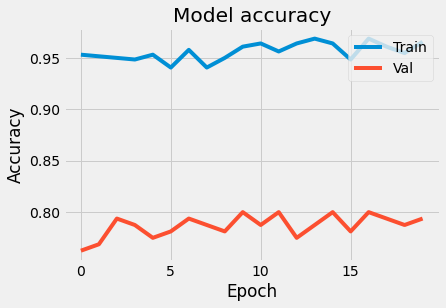

<Figure size 432x288 with 0 Axes>

In [89]:
plot_measures(hist=hist)

In [95]:
model.evaluate(X_test, y_test)[1]

7/7 [==============================] - 0s 17ms/step - loss: 0.5997 - accuracy: 0.7900


0.7900000214576721

**Prediction on new data using above model**

In [97]:
example = "I got the chef's special and it got to my table cold. The soup was bland, meat was tough, and the waiter took half an hour to get our bill. I would not come here again."

In [98]:
example = [example.translate(table)]

In [99]:
example

['I got the chefs special and it got to my table cold The soup was bland meat was tough and the waiter took half an hour to get our bill I would not come here again']

In [100]:
tokenizer.fit_on_texts(example)

In [101]:
example = tokenizer.texts_to_sequences(example)

In [102]:
example = pad_sequences(example, padding='post', maxlen=max_len)

In [104]:
model.predict(example)
##hence this example is predicted to be negative

array([[0.00012018]], dtype=float32)

In [110]:
def predict(review):
    review = [review.translate(table)]
    tokenizer.fit_on_texts(review)
    review = tokenizer.texts_to_sequences(review)
    review = pad_sequences(review, padding='post', maxlen=max_len)
    for i in model.predict(review):
        if i > 0.5:
            print('review is positive')
        else:
            print('review is negative')

In [113]:
predict("Over priced microwaved food! Portions for pick up were tiny and my chicken cold  nothing tasted authentic! I make a better Alfredo sauce from scratch told the hubby not order from here to but he insisted and it was a waste of $100 dollars!!!")

review is negative


In [142]:
predict("This is hands down the best i have been to. Hosts are always super sweet. Severs are always seem to be happy.")

review is positive


**Implementation of 1D convnet**

In [146]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [155]:
model = Sequential()
embedding_layer = Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=max_len , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(64, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

In [156]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          200000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 94, 64)            44864     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 12, 64)            28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 273,665
Trainable params: 73,665
Non-trainable params: 200,000
__________________________________________

In [157]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [158]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
10/10 [==============================] - 0s 20ms/step - loss: 0.6888 - accuracy: 0.6047 - val_loss: 0.7080 - val_accuracy: 0.5813
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 0.6206 - accuracy: 0.6844 - val_loss: 0.6495 - val_accuracy: 0.6438
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 0.5279 - accuracy: 0.7922 - val_loss: 0.6375 - val_accuracy: 0.6750
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 0.4823 - accuracy: 0.7906 - val_loss: 0.6409 - val_accuracy: 0.6687
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.4122 - accuracy: 0.8438 - val_loss: 0.7208 - val_accuracy: 0.6500
Epoch 6/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3579 - accuracy: 0.8703 - val_loss: 0.5910 - val_accuracy: 0.7188
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.3034 - accuracy: 0.9062 - val_loss: 0.6852 - val_accuracy: 0.6812
Epoch 8/10
10

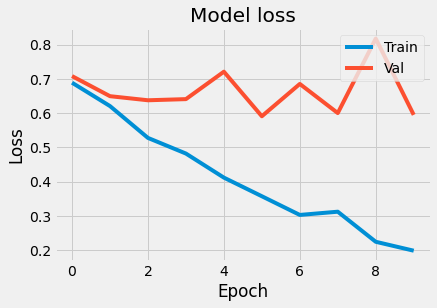

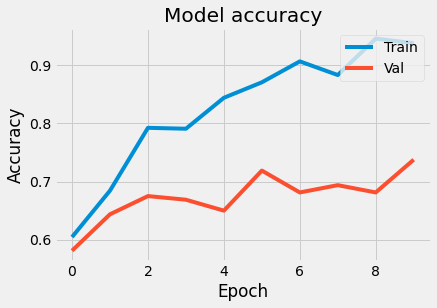

<Figure size 432x288 with 0 Axes>

In [159]:
plot_measures(hist=hist)

In [161]:
model.evaluate(X_test, y_test)[1]

7/7 [==============================] - 0s 2ms/step - loss: 0.5605 - accuracy: 0.7200


0.7200000286102295